# Generate computational SPDs
(This code is from Jupyter Notebook, please check `.ipnb` file if modify it.)

In [1]:
import numpy as np
import scipy
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
import os
from spectral_util import interp_spd

import colour
from colour.utilities import numpy_print_options
from colour.temperature import CCT_to_xy_CIE_D
from PIL import Image

import pickle
import pdb

In [2]:
def get_d65spd():
    CCT_D65 = 6500 * 1.4388 / 1.4380
    xy = CCT_to_xy_CIE_D(CCT_D65)
    with numpy_print_options(suppress=True):
        spd_d65 = colour.sd_CIE_illuminant_D_series(xy)
    return spd_d65


In [3]:
def approx_bySublights(spd_target, spds_sub):
    spd_inv = np.linalg.pinv(spds_sub)
    x = np.dot(spd_inv, spd_target)
    spd_approx = np.dot(spds_sub, x)
    return spd_approx, x

# Specification

In [4]:
_param_set = '200to600nm_narrow'
# _param_set = '200to600nm_wide'
_params = {
    '200to600nm_narrow':{'wl_start': 200, 'wl_end': 600, 'band_steps': 10, 'band_resolution': 1, 'wl_FWHM': 20},
    '200to600nm_wide':  {'wl_start': 200, 'wl_end': 600, 'band_steps': 10, 'band_resolution': 1, 'wl_FWHM': 40},
    }
param = _params[_param_set]

_wl_bands = np.arange(param['wl_start'], param['wl_end'], param['band_steps'])
_df = pd.DataFrame({'wavelength':_wl_bands, })
_df.loc[:,_wl_bands] = 0

for wl in _wl_bands:
    _df.loc[_df.loc[:,'wavelength']==wl,wl] = 1

wl_sensor = _wl_bands


## FWHM
FWHM (半値幅): 

$$
\begin{aligned}

\lambda_{\mathrm{FWHM}}  \ &{\sim}\   2\sigma\sqrt{2\ln{2}}
\\
\sigma 
\ &{\sim}\ 
\frac{ \lambda_\mathrm{FWHM}}{ (2\sqrt{2\ln{2}}) }
\\
\sigma
\ &{\sim}\ 
\frac{\lambda_\mathrm{FWHM}}{2.35}

\end{aligned}
$$


In [5]:
wl_FWHM = param['wl_FWHM']
var_FEHM = pow(wl_FWHM/2.35, 2)
f"σ={var_FEHM}, for {wl_FWHM} nm of FWHM"

'σ=72.4309642372114, for 20 nm of FWHM'

## Peek
e.g.  
- Range: $450\text{--}950 \ \mathrm{nm}$ (or $400\text{--}1000 \ \mathrm{nm}$)  
- ${\lambda}_\mathrm{peek} = 460\text{--}940 \ \mathrm{nm}$ with $20 \ \mathrm{nm}$ (or $410\text{--}990 \ \mathrm{nm}$ with $20 \ \mathrm{nm}$) band steps.


In [6]:
wl_start = param['wl_start']
wl_end = param['wl_end']
wl_res = param.get('band_resolution',5)
wl = np.array(range(wl_start, wl_end+1, wl_res))
wl_width = wl_end - wl_start
wl_bandstep = param['band_steps']
# wl_peeks = np.array(
#     range(wl_start+round(wl_bandstep/2), wl_end+1, wl_bandstep))
wl_peeks = np.array(range(wl_start, wl_end+1, wl_bandstep))
print("Range: {0}--{1}, ".format(wl_peeks[0],
      wl_peeks[-1]), "Band steps: {}".format(wl_bandstep))

label_wl = '{0}to{1}nm'.format(wl_start, wl_end, )


Range: 200--600,  Band steps: 10


In [7]:
print(np.array(wl_peeks))
print('# of LEDs: {}'.format(len(wl_peeks)))

[200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370
 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550
 560 570 580 590 600]
# of LEDs: 41


# Make SPDs

In [8]:
spds_fill_ = np.array([
    np.exp(-pow(wl - wl_peek_, 2) / var_FEHM)
    for wl_peek_ in wl_peeks
    ])
spds_fill = spds_fill_.T
spds_fill.shape

(401, 41)

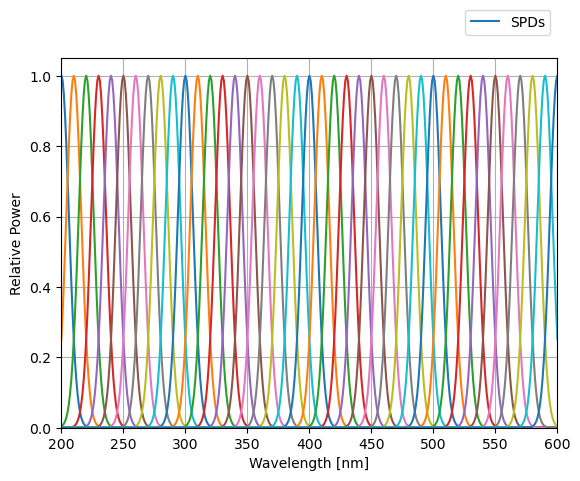

In [9]:
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
plt.plot(
    wl, spds_fill, label=[
    'SPDs'if i == 0 else '_nolegend_' for i in range(spds_fill.shape[1])])
plt.xlim([wl[0], wl[-1]])
plt.ylim([0, plt.ylim()[1]])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Power')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1.15))


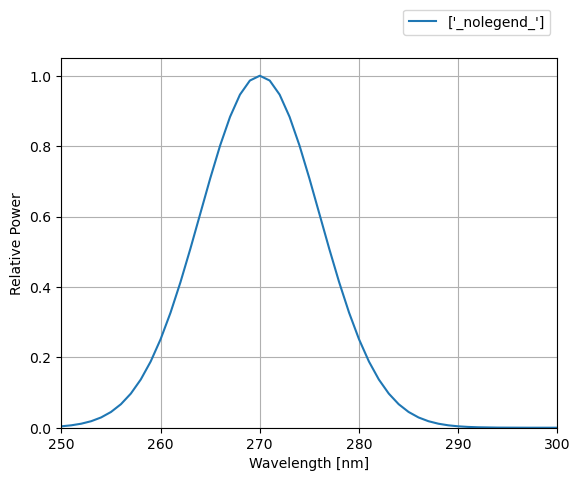

In [10]:
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
plt.plot(
    wl, spds_fill[:,7], label=[
    'SPDs'if i == 0 else '_nolegend_' for i in [7,]])
# plt.xlim([wl[0], wl[-1]])
plt.xlim([250, 300])
plt.ylim([0, plt.ylim()[1]])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Power')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1.15))


# Make Camera Spectral Sensitivity

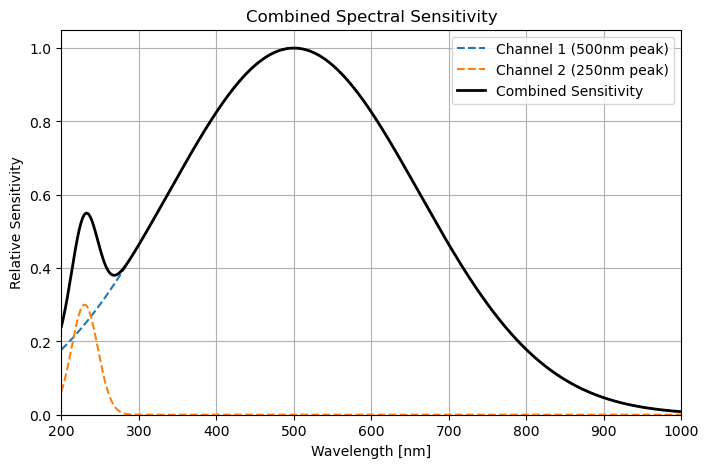

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータ設定
wl_start = 200  # nm
wl_end = 1000   # nm
wl_step = 1     # 分解能
wavelengths = np.arange(wl_start, wl_end + 1, wl_step)

# チャネルごとの設定
channels = [
    {"peak": 500, "fwhm": 380, "max_val": 1.0},
    {"peak": 230, "fwhm": 40, "max_val": 0.3}
]

# 感度行列（列ごとにチャネル）
sensitivity_all = []

for ch in channels:
    sigma = ch["fwhm"] / 2.355
    sensitivity = np.exp(-0.5 * ((wavelengths - ch["peak"]) / sigma) ** 2)
    sensitivity /= np.max(sensitivity)
    sensitivity *= ch["max_val"]
    sensitivity_all.append(sensitivity)

# スタック（shape: (len(wl), 2)）
sensitivity_all = np.stack(sensitivity_all, axis=1)

# 合成：単純加算 → 正規化
combined_sensitivity = np.sum(sensitivity_all, axis=1)
combined_sensitivity /= np.max(combined_sensitivity)

# 描画
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, sensitivity_all[:, 0], label='Channel 1 (500nm peak)', linestyle='--')
plt.plot(wavelengths, sensitivity_all[:, 1], label='Channel 2 (250nm peak)', linestyle='--')
plt.plot(wavelengths, combined_sensitivity, label='Combined Sensitivity', color='black', linewidth=2)
plt.title('Combined Spectral Sensitivity')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Sensitivity')
plt.grid(True)
plt.legend()
plt.xlim(wl_start, wl_end)
plt.ylim(0, 1.05)
plt.show()


# Simulation